# Model Architecture

In this notebook, i choice best model is optimized CNN with pretrained model and Spatial Transformer layer

Load model saved

In [1]:
import time
import numpy as np
import pandas as pd
from glob import glob

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.layers import Input, merge, concatenate
from spatial_transformer import SpatialTransformer

def locnet():
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((64, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(16, (7, 7), padding='valid', input_shape=(64, 64, 3)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(32, (5, 5), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(128, activation='elu'))
    locnet.add(Dense(64, activation='elu'))
    locnet.add(Dense(6, weights=weights))

    return locnet

base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(64, 64, 3))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

added0_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

stn_model = Sequential()
stn_model.add(Lambda(
    lambda x: 2*x - 1.,
    input_shape=(64, 64, 3),
    output_shape=(64, 64, 3)))
stn_model.add(BatchNormalization())
stn_model.add(SpatialTransformer(localization_net=locnet(),
                                 output_size=(64, 64)))

added_model = Model(inputs=stn_model.input, outputs=added0_model(stn_model.output))

inp = Input(batch_shape=(None, 5))
# out = Dense(8)(inp)
extra_model = Model(input=inp, output=inp)

x = concatenate([added_model.output,
           extra_model.output])

# x = Dropout(0.5)(x)
# x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model =  Model(input=[added_model.input,
                extra_model.input],
                output=x)

model.load_weights('pretrained_extradata_stn_CNN.best.from_scratch.hdf5')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("in..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


This fuction bellow resize and convert images to numpy array

In [2]:
from keras.preprocessing import image 

def path_to_tensor(img_path, shape=(64, 64)):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)/255
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.vstack([np.expand_dims(x, axis=0)])

And function to preprocessing extra data

In [3]:
def features_preprocessing(age, gender, view):
    agetype = age[-1]
    age = int(age[:-1])
    age = {
              'Y': lambda x: x,
              'M': lambda x: x / 12.,
              'D': lambda x: x / 365.
            }[agetype](age)
    if (gender == 'M'):
        m = 1
        f = 0
    else:
        m = 0
        f = 1
        
    if (view == 'AP'):
        ap = 1
        pa = 0
    else:
        ap = 0
        pa = 1
    return np.array([[age, f, m, ap, pa]])

In [4]:
def predict(img, age, gender, view):
    return model.predict([path_to_tensor(img), features_preprocessing(age, gender, view)])

In [5]:
import matplotlib.pyplot as plt 
import cv2
%matplotlib inline

def show_image(img_path):
    image = cv2.imread(img_path)
    plt.imshow(image)
    plt.show()

I will test with 20 random samples

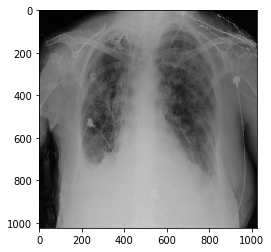

True: Fibrosis, Predict: Finding, confident: 0.58584183


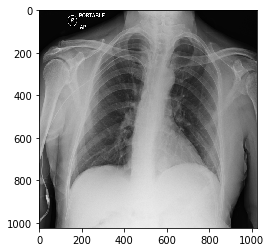

True: No Finding, Predict: No Finding, confident: 0.074103214


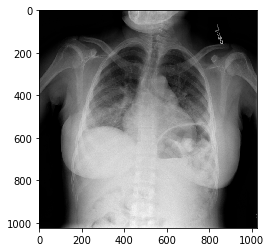

True: Infiltration, Predict: Finding, confident: 0.7584118


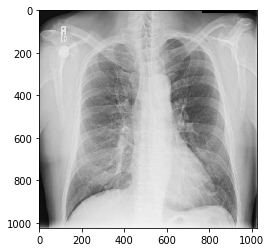

True: No Finding, Predict: No Finding, confident: 0.10266427


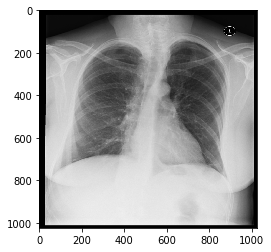

True: No Finding, Predict: No Finding, confident: 0.10112806


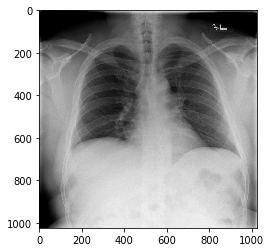

True: No Finding, Predict: No Finding, confident: 0.12532106


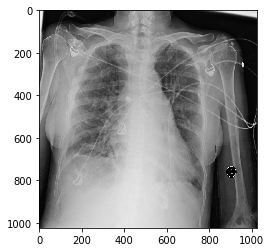

True: Atelectasis|Effusion|Infiltration, Predict: Finding, confident: 0.71254677


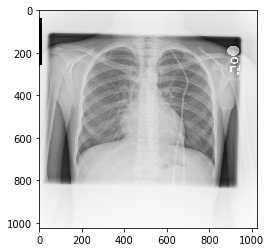

True: No Finding, Predict: No Finding, confident: 0.15094823


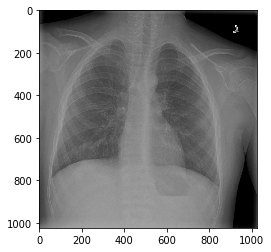

True: No Finding, Predict: No Finding, confident: 0.20290725


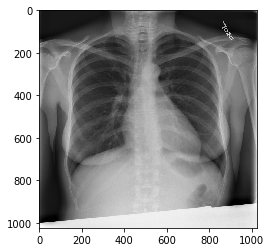

True: No Finding, Predict: No Finding, confident: 0.08226491


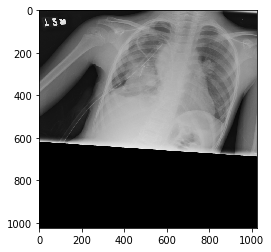

True: Pneumothorax, Predict: No Finding, confident: 0.48332688


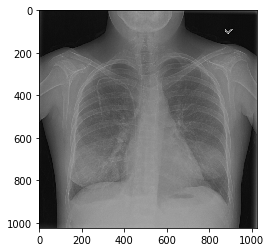

True: Infiltration|Nodule, Predict: Finding, confident: 0.53442746


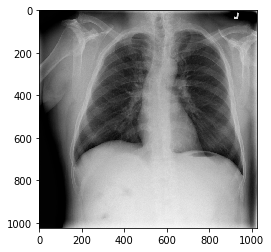

True: No Finding, Predict: No Finding, confident: 0.059335917


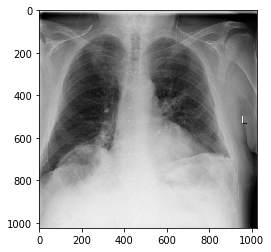

True: Infiltration, Predict: No Finding, confident: 0.4099386


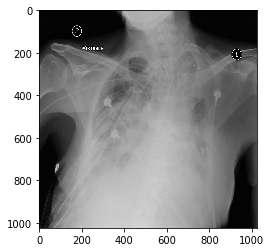

True: No Finding, Predict: Finding, confident: 0.50460964


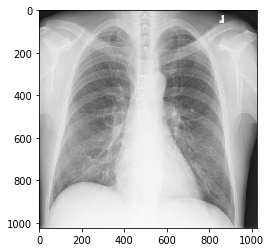

True: No Finding, Predict: No Finding, confident: 0.06923907


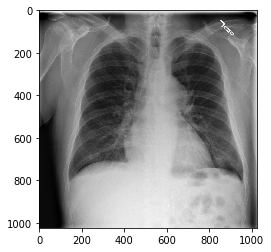

True: Edema|Effusion|Nodule, Predict: No Finding, confident: 0.2226791


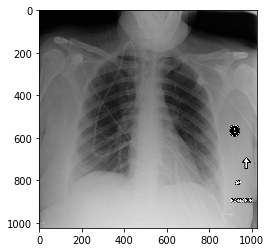

True: Infiltration, Predict: No Finding, confident: 0.10491619


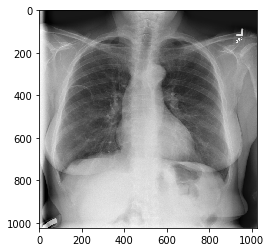

True: No Finding, Predict: No Finding, confident: 0.055492554


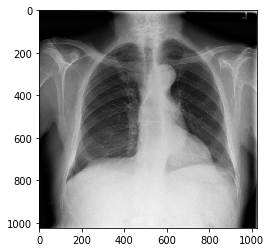

True: Atelectasis, Predict: No Finding, confident: 0.1684653


In [6]:
df = pd.read_csv('sample/sample_labels.csv').sample(20)

for i in range(len(df)):
    img, age, gender, view = 'sample/images/' + df.iloc[i]['Image Index'], df.iloc[i]['Patient Age'], df.iloc[i]['Patient Gender'], df.iloc[i]['View Position']
    pre = predict(img, age, gender, view)[0][0]
    show_image(img)
    y_true = df.iloc[i]['Finding Labels']
    y_predict = "Finding" if (pre >= 0.5) else "No Finding"
    print ("True: %s, Predict: %s, confident: %s" % (y_true, y_predict, pre))